In [191]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import MetaTrader5 as mt5
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import layers

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [192]:
from data import Data

df = Data()
df = df.get_original_data()
# df.pop("real_volume")
# df = df[5::6]
for i in range(len(df["time"])):
    df["time"][i] = i
date_time = df.pop(("time"))

df = df.drop(columns=["real_volume"])

start_date = pd.to_datetime('2022-01-01 00:00:00')
date_time = start_date + pd.to_timedelta(date_time, unit='H')

C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_15336\1755005804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"][i] = i
C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_15336\1755005804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"][i] = i
C:\Users\LocalAdmin\AppData\Local\Temp\ipykernel_15336\1755005804.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["time"][i] = i
C:\Users\LocalAdmin\AppData\Loc

In [193]:
plot_cols = ['close', 'tick_volume', 'spread']
plot_features = df[plot_cols]
plot_features.index = df["time"]
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][0:500]
plot_features.index = df["time"][0:500]
_ = plot_features.plot(subplots=True)

KeyError: 'time'

In [ ]:
len(df)

481

In [194]:
df.describe()

,open,high,low,close,tick_volume,spread
count,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000
mean,1.132871,1.133460,1.132256,1.132831,2525.459459,0.904366
std,0.007385,0.007388,0.007440,0.007429,1878.485614,3.240242
min,1.112680,1.113690,1.112140,1.112690,1.000000,0.000000
25%,1.129750,1.130460,1.129320,1.129750,1061.000000,0.000000
50%,1.132870,1.133460,1.132300,1.132860,1972.000000,0.000000
75%,1.136190,1.136770,1.135530,1.136180,3504.000000,0.000000
max,1.147900,1.148290,1.147370,1.147890,14559.000000,21.000000


In [195]:
# Lets split the data:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

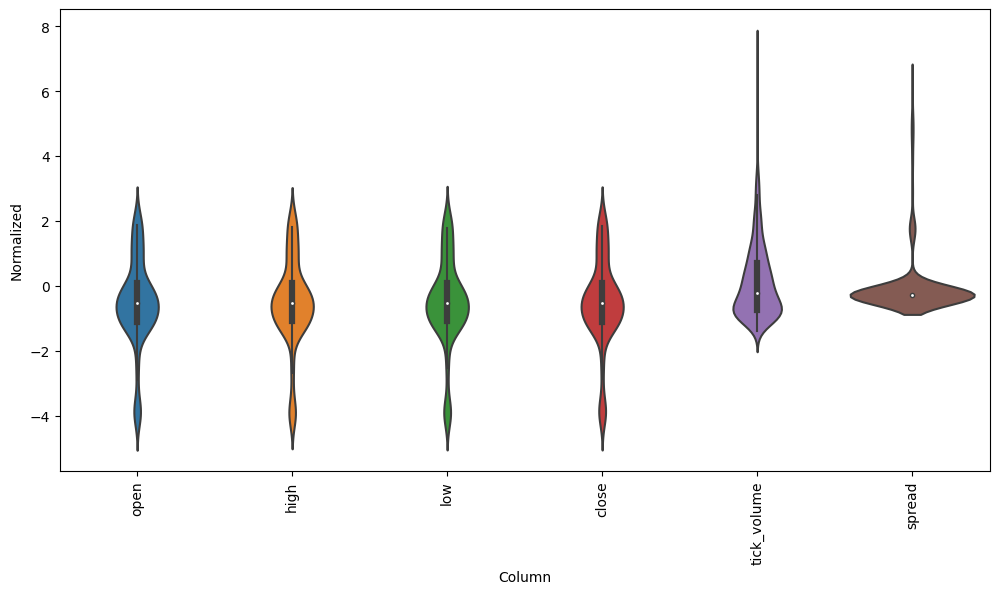

In [196]:
# We should really not just normalize everything based on future data, normalization should be done for each window!
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [197]:
from data import WindowGenerator
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['close'], train_df=train_df, test_df=test_df, val_df=val_df)

w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     train_df=train_df, test_df=test_df, val_df=val_df,
                     label_columns=['close'])

w1
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [198]:
## let's split the data! 
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


In [199]:
# Let's try it out! 
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 6)
Inputs shape: (3, 6, 6)
Labels shape: (3, 1, 1)


In [200]:
w2.example = example_inputs, example_labels

AttributeError: can't set attribute

In [201]:
def plot(self, model=None, plot_col='close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

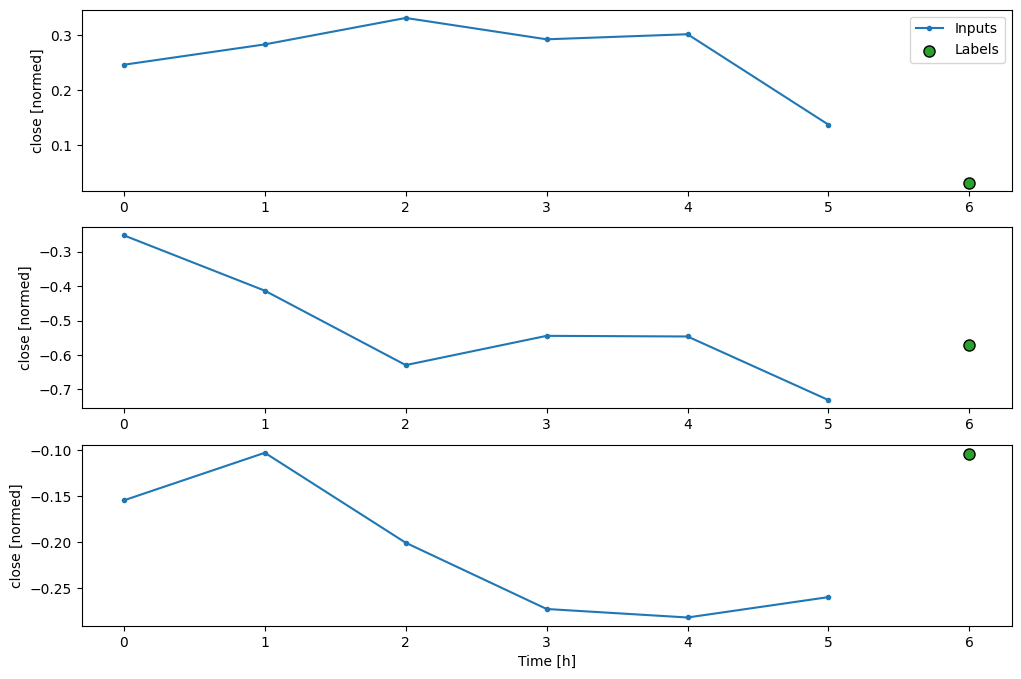

In [202]:
w2.plot()

In [203]:
# tf create dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [204]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example


In [205]:
# Each element is an (inputs, label) pair.
w2.train.element_spec


(TensorSpec(shape=(None, 6, 6), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [206]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [207]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['close'],
    train_df=train_df, test_df=test_df, val_df=val_df)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']

In [208]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 6)
Labels shape (batch, time, features): (32, 1, 1)


In [209]:
# Before going to more advanced models, it'd be good to create a baseline
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [210]:
# Baseline will be the evaluate model
baseline = Baseline(label_index=column_indices['close'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

3/3 [==============================] - 0s 2ms/step - loss: 0.0149 - mean_absolute_error: 0.0840


In [211]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['close'], train_df=train_df,
    test_df=test_df, val_df=val_df)

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['close']

In [212]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)


Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


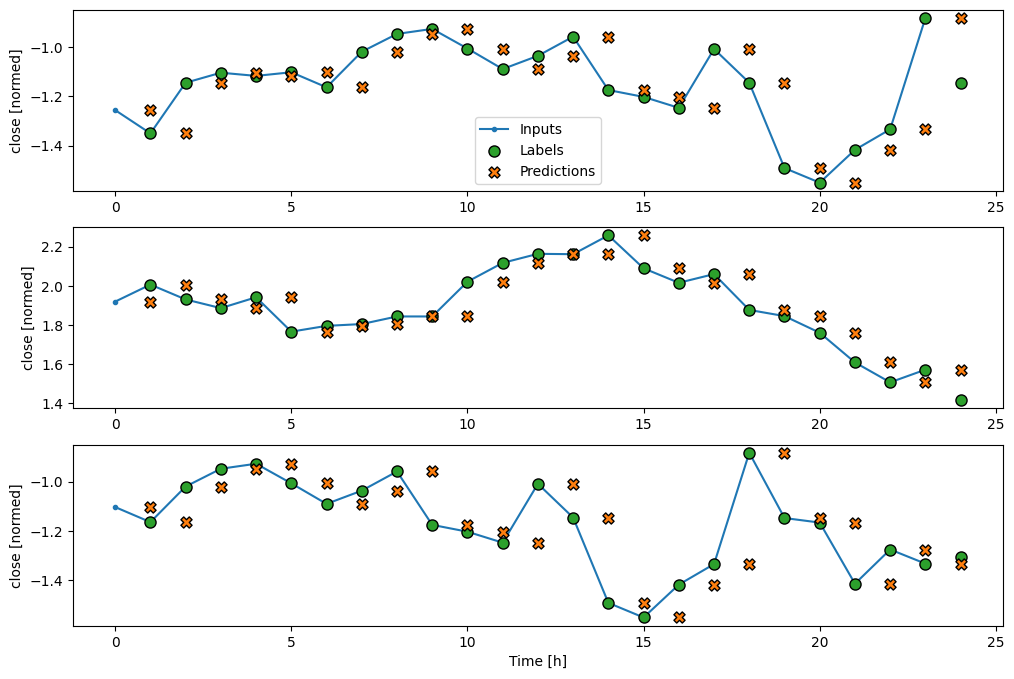

In [213]:
wide_window.plot(baseline)


In [214]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)


Input shape: (32, 1, 6)
Output shape: (32, 1, 1)


In [215]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss='mean_squared_logarithmic_error',
                optimizer="adam",
                metrics=['mae'])

  history = model.fit(window.train, epochs=MAX_EPOCHS
                      # validation_data=window.val,
                      # callbacks=[early_stopping]
                      )
  return history


In [216]:
# patience = 2
# MAX_EPOCHS = 20
# model = linear
# window = single_step_window

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                     patience=patience,
#                                                     mode='min')

# model.compile(loss=tf.keras.losses.MeanSquaredError(),
#             optimizer=tf.keras.optimizers.Adam(),
#             metrics=[tf.keras.metrics.MeanAbsoluteError()])

# history = model.fit(window.train, epochs=MAX_EPOCHS,
#                     validation_data=window.val,
#                     callbacks=[early_stopping])
print(single_step_window)


Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['close']


In [217]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0668 - mae: 0.5318
Epoch 2/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0620 - mae: 0.5178
Epoch 3/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0568 - mae: 0.5059
Epoch 4/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0522 - mae: 0.4966
Epoch 5/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0484 - mae: 0.4883
Epoch 6/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0449 - mae: 0.4826
Epoch 7/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0422 - mae: 0.4777
Epoch 8/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0398 - mae: 0.4733
Epoch 9/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0376 - mae: 0.4701
Epoch 10/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0357 - mae: 0.4654
Epoch 11/20
11/11 [==============================] - 0s 2ms/step - lo

Input shape: (32, 24, 6)
Output shape: (32, 24, 1)


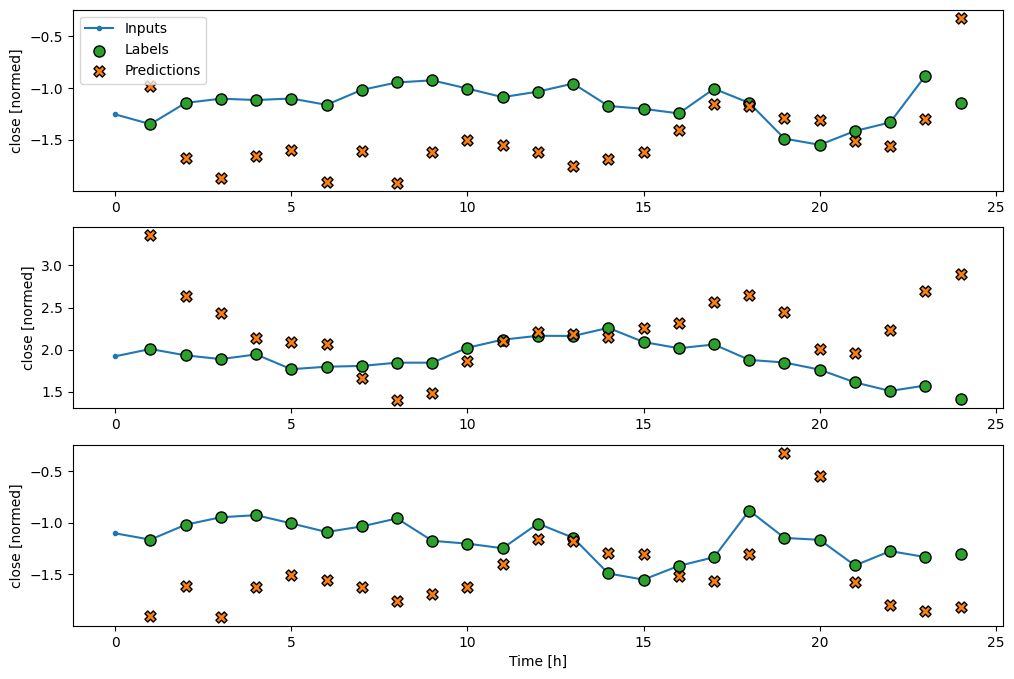

In [218]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)
wide_window.plot(linear)


In [219]:
# Here comes the dense model:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)


Epoch 1/20
11/11 [==============================] - 1s 1ms/step - loss: 0.0886 - mae: 0.6897
Epoch 2/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0071 - mae: 0.3885
Epoch 3/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0053 - mae: 0.3106
Epoch 4/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.2389
Epoch 5/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.2138
Epoch 6/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0032 - mae: 0.2139
Epoch 7/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0031 - mae: 0.2110
Epoch 8/20
11/11 [==============================] - 0s 2ms/step - loss: 0.0030 - mae: 0.2067
Epoch 9/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.2083
Epoch 10/20
11/11 [==============================] - 0s 1ms/step - loss: 0.0029 - mae: 0.2090
Epoch 11/20
11/11 [==============================] - 0s 1ms/step - lo